<a href="https://colab.research.google.com/github/BluBloos/3D-Hand-Tracking/blob/main/src/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [1]:
# RUN THIS BLOCK ONLY WHEN IN COLAB

!echo "Initializing github repository"
!ls -la
!rm -r .config/
!rm -r sample_data/
!git clone https://github.com/BluBloos/QMIND2021-2022/ .

Initializing github repository
total 60
drwxr-xr-x 1 root root 4096 Mar 30 21:43 .
drwxr-xr-x 1 root root 4096 Mar 30 21:20 ..
drwxr-xr-x 1 root root    0 Mar 30 21:35 data
drwxr-xr-x 8 root root 4096 Mar 30 21:43 .git
-rw-r--r-- 1 root root  172 Mar 30 21:28 .gitignore
drwxr-xr-x 3 root root 4096 Mar 30 21:28 MessyCloset
drwxr-xr-x 2 root root 4096 Mar 30 21:28 paper
-rw-r--r-- 1 root root 2308 Mar 30 21:28 README.md
drwxr-xr-x 4 root root 4096 Mar 30 21:28 RHD_small
-rwxr-xr-x 1 root root   30 Mar 30 21:28 run.sh
drwxr-xr-x 4 root root 4096 Mar 30 21:29 SH_RHD
drwxr-xr-x 4 root root 4096 Mar 30 21:28 src
-rw-r--r-- 1 root root 4460 Mar 30 21:28 TODO.md
drwxr-xr-x 2 root root 4096 Mar 30 21:28 .vscode
rm: cannot remove '.config/': No such file or directory
rm: cannot remove 'sample_data/': No such file or directory
fatal: destination path '.' already exists and is not an empty directory.


In [2]:
# ALWAYS RUN THIS BLOCK, COLAB OR NOT

# Download updated project from Github.
!git pull

##### HANDLE DIFFS WHEN RUNNING IN COLAB #####
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab:", IN_COLAB)
import sys
if (IN_COLAB):
  sys.path.insert(1, '/content/src/')
##### HANDLE DIFFS WHEN RUNNING IN COLAB #####

########### TEST GPU AND RAM OF COLLAB INSTANCE ###########
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
########### TEST GPU AND RAM OF COLLAB INSTANCE ###########

######### EXTERNAL LIBRARIES #########
import os
import pickle
import matplotlib.pyplot as plt
import imageio
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, MaxPool2D
from tensorflow.keras import Model
print("TensorFlow version:", tf.__version__)
#NOTE: Good resource. -> https://www.tensorflow.org/tutorials/quickstart/advanced
import cv2 # opencv, for image resizing.
######### EXTERNAL LIBRARIES #########

############## HELPER FUNCTIONS ############## 
# NOTE(Noah): Stole this function from Stackoverflow :)
def rgb2gray(rgb):
    return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=2)
def resize(img, size):
    return cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
############## HELPER FUNCTIONS ############## 

Already up to date.
In Colab: True
Not connected to a GPU
Your runtime has 27.3 gigabytes of available RAM
You are using a high-RAM runtime!
TensorFlow version: 2.8.0


# MODEL LOADING

In [3]:
# TODO(Noah): Get the MANO folders hosted in GCS so that this works again.
#   We note that this cost was tested and is in full working order, so 
#   the only thing not working is the lack of existence of MANO_DIR. 

# Setup some params.
IMAGE_SIZE = 224
GRAYSCALE = False
IMAGE_CHANNELS = 1 if GRAYSCALE else 3
BATCH_SIZE = 32
MANO_DIR = "mano_v1_2" if IN_COLAB else "../mano_v1_2"

from mobilehand import MAKE_MOBILE_HAND
from mobilehand_lfuncs import LOSS_3D

MOBILE_HAND = MAKE_MOBILE_HAND(IMAGE_SIZE, IMAGE_CHANNELS, BATCH_SIZE, MANO_DIR)

# INTEGRATION TEST
input_test = tf.random.uniform(shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
input_test = tf.cast(input_test, tf.float32)
output_test = MOBILE_HAND(input_test)
print(output_test)

# The lower training loop assumes that the model is set as such.
model = MOBILE_HAND

# The lower training loop also assumes that we have the loss function set like so.
loss_fn = lambda pred, gt : LOSS_3D(pred,gt) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               183744    
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 288)               83232     
                                                                 
 dropout_2 (Dropout)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 61)                17629     
                                                                 
Total params: 284,605
Trainable params: 284,605
Non-trainable params: 0
_________________________________________________________________
Unable to find MANO_RIGHT.pkl


AttributeError: ignored

# DATA LOADING

In [4]:
# more params to setup.
TRAIN_AMOUNT = 192 # must be multiple of 32
TEST_AMOUNT = 96 # must be multiple of 32

# Check if the dataset has been parsed yet. If not, parse.
data_dir = 'RHD_small' if IN_COLAB else '../RHD_small'
anno_dir = data_dir
parsed_data_dir = 'SH_RHD' if IN_COLAB else '../SH_RHD'
import parsing_data
if not os.path.isdir(parsed_data_dir):
  os.mkdir(parsed_data_dir)
  os.mkdir(os.path.join(parsed_data_dir, 'evaluation'))
  os.mkdir(os.path.join(parsed_data_dir, 'evaluation', 'color'))
  os.mkdir(os.path.join(parsed_data_dir, 'training'))
  os.mkdir(os.path.join(parsed_data_dir, 'training', 'color'))
  parsing_data.parse_dataset("training", 203, data_dir, parsed_data_dir) # parse for the training examples
  parsing_data.parse_dataset("evaluation", 203, data_dir, parsed_data_dir) # parse for the evaluation examples

data_dir = parsed_data_dir

# Load in the testing and training images.
x_train = np.zeros( (TRAIN_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) )
y_train = np.zeros( (TRAIN_AMOUNT, 21, 3) )
x_test = np.zeros( (TEST_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) ) 
y_test = np.zeros( (TEST_AMOUNT, 21, 3) )

def LoadData(dataAmount, dataType, anno_dir, np1, OUTPUT = False):
  path = os.path.join(data_dir, dataType, 'color')
  count = 0
  index = 0
  for filename in os.listdir(path):
    sample_id = filename[0:5]
    sample_id = int(sample_id)
    if OUTPUT:
      with open(os.path.join(anno_dir, dataType, 'anno_%s.pickle' % dataType), 'rb') as fi:
        anno_all = pickle.load(fi)
      # TODO(Noah): Here we have the issue of loading in the annotations sparsely into a numpy array,
      # but the training images are loaded in densely from the preparsed dataset. 
      # So we have an issue where things are not lined up.
      # 
      # Generally, the entire problem here changes when we start to consider the fact that we are going to
      # do data streaming.
      # So when we data stream, what we want to happen is a download of a single batch, where we get the train
      # images, the test images, along with the ground truths.
      #
      # Thus, the task is as follows. We need to add onto the preparsing routine the ability to output the
      # annotations alongside the images. 
      kp_visible = (anno_all[sample_id]['uv_vis'][:, 2] == 1)
      case1 = np.sum(kp_visible[0:21])
      case2 = np.sum(kp_visible[21:])
      LEFT_HAND = (case1>case2)
      if LEFT_HAND:
        np1[index][:,:] = anno_all[sample_id]['xyz'][0:21]
      else:
        np1[index][:,:] = anno_all[sample_id]['xyz'][21:]      
    else:
      filePath = os.path.join(path, filename)
      image = imageio.imread(filePath)
      _image = image.astype('float32')
      if GRAYSCALE:
        _image = rgb2gray(_image / 255)
      else:
        _image = _image / 255
      _image = resize(_image, IMAGE_SIZE)
      
      np1[count, :, :, :] = _image
    
    index += 1
    count += 1
    if (count >= dataAmount):
      break

print("Loading in the training data samples...")
start_time = time.time()
LoadData(TRAIN_AMOUNT, 'training', data_dir, x_train)
x_train = x_train.astype('float32')
LoadData(TRAIN_AMOUNT, 'training', anno_dir, y_test, OUTPUT=True)
y_train = y_train.astype('float32')
end_time = time.time()
print('Elapsed for LoadData training', end_time - start_time, 's')

print("Loading in the evaluation data samples...")
start_time = time.time()
LoadData(TEST_AMOUNT, 'evaluation', data_dir, x_test)
x_test = x_test.astype('float32')
LoadData(TEST_AMOUNT, 'evaluation', anno_dir, y_test, OUTPUT = True)
y_test = y_test.astype('float32')
end_time = time.time()
print('Elapsed for LoadData evaluation', end_time - start_time, 's')

# Test print one of the images from the dataset.
_test = x_train[0] 
plt.imshow(_test)
plt.show()
# _test = y_train[0]
# plt.imshow(np.squeeze(_test))
# plt.show()

# Batch the data for tensorflow.
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


Begin single hand parse
00002.png
00005.png
00006.png
00007.png
00008.png
00013.png
00014.png
00018.png
00023.png
00026.png
00027.png
00032.png
00035.png
00036.png
00037.png
00039.png
00040.png
00041.png
00042.png


KeyboardInterrupt: ignored

# TRAINING LOOP

In [18]:
class StupidSimpleLossMetric():
    def __init__(self):
        self.losses = [] # empty python array 
    def __call__(self, loss):
        self.losses.append(loss)
    def result(self):
        return sum(self.losses) / len(self.losses)
    def reset_states(self):
        self.losses = []

optimizer = tf.keras.optimizers.Adam() # defaults should work just fine
train_loss = StupidSimpleLossMetric()
test_loss = StupidSimpleLossMetric()

# Loss function unit test
input = tf.zeros([1, 21,3])  # mock pred of all zeros
label = np.expand_dims(y_train[0], axis=0)
loss = loss_fn(input, label) 
print('Loss for pred of all zeros', loss.numpy())
#loss2 = loss_fn(label, label)
#print('Loss for perfect prediction', loss2.numpy())
input2 = tf.ones([1, 21, 3])
loss3 = loss_fn(input2, label)
print('Loss for pred of all ones', loss3.numpy())

@tf.function
def train_step(input, gt):
    with tf.GradientTape() as tape:
        predictions = model(input)
        #loss = loss_func(predictions, segmentation_masks)
        #loss = np.dot(tf.reshape(segmentation_masks, [102400], tf.reshape(predictions, [102400])
        loss = loss_fn(predictions, gt)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
    #train_accuracy(labels, predictions)
  
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  return loss_fn(predictions, labels)
  #test_accuracy(labels, predictions)

NameError: ignored

deb http://packages.cloud.google.com/apt gcsfuse-bionic main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   130k      0 --:--:-- --:--:-- --:--:--  123k
OK
Get:1 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5,388 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:10 http://archive.ubuntu.co

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


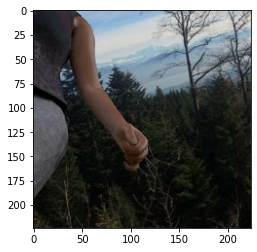

tf.Tensor(
[[[0.18052535 0.1685484  0.20394865]
  [0.19452909 0.18793501 0.22064382]
  [0.18163015 0.17770858 0.20908114]
  ...
  [0.6116528  0.63136685 0.6471592 ]
  [0.6416085  0.66132236 0.6771148 ]
  [0.5555655  0.5752794  0.59107184]]

 [[0.16023177 0.14825484 0.18365505]
  [0.17342523 0.16683114 0.19953994]
  [0.16473538 0.1608138  0.19218634]
  ...
  [0.49836227 0.5153848  0.5284857 ]
  [0.5291665  0.54618895 0.55928993]
  [0.62075436 0.637777   0.65087783]]

 [[0.1465575  0.13458057 0.16998078]
  [0.1631461  0.15655205 0.18926083]
  [0.15551497 0.15159342 0.18296595]
  ...
  [0.5360159  0.551029   0.5625694 ]
  [0.64873874 0.66375196 0.67529225]
  [0.6033066  0.61831963 0.62986004]]

 ...

 [[0.19545382 0.15623811 0.11702244]
  [0.1540768  0.1148611  0.07564542]
  [0.2176846  0.17891768 0.1394776 ]
  ...
  [0.01960785 0.01960785 0.01960785]
  [0.01960784 0.01960784 0.01960784]
  [0.01960785 0.01960785 0.01960785]]

 [[0.09004257 0.05082688 0.01161119]
  [0.12517558 0.0859599  0

In [12]:
from matplotlib.image import imread

from google.cloud import storage
from google.colab import auth
#!gcloud config set project qmind-345413
auth.authenticate_user()
!echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!sudo apt-get -y -q update
!sudo apt-get -y -q install gcsfuse
!mkdir -p data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 shd_final data
#!gsutil cp -r list[] testing/

def download_image(path):
  image = imageio.imread(path)
  _image = image.astype('float32')
  if GRAYSCALE:
      _image = rgb2gray(_image / 255)
  else:
      _image = _image / 255
  _image = resize(_image, IMAGE_SIZE)
  return _image

train_list = os.listdir('/content/data/training/color')
eval_list = os.listdir('/content/data/evaluation/color')


x_train = np.zeros( (32, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) )
y_train = np.zeros( (32, 21, 3) )
x_test = np.zeros( (32, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) ) 
y_test = np.zeros( (32, 21, 3) )



TOTAL_IMAGES = 1
s
path = '/content/data'


In [ ]:
# TODO: Reimplement loading in the saved model weights
checkpoint_path = MANO_DIR = "checkpoints/" if IN_COLAB else "../checkpoints/"
!mkdir $checkpoint_path

last_checkpoint = -1
if (last_checkpoint > -1):
  model.load_weights(os.join(checkpoint_path, "cp-{last_checkpoint:04d}.ckpt"))

EPOCHS = 10 # sure...

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  #train_accuracy.reset_states()
  test_loss.reset_states()
  #test_accuracy.reset_states()

  #range goes up to total images//32
  for times in range(1):

    for i in range(32):
      train_image = download_image(os.path.join(path,'training/color',train_list[i+times*32]))
      eval_image = download_image(os.path.join(path, 'evaluation/color',eval_list[i+times*32]))
      x_train[i,:,:,:]=train_image
      x_test[i,:,:,:] = eval_image
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    loss = train_step(x_train, y_train)
    train_loss(loss.numpy())

    loss_test = test_step(x_test, y_test)
    test_loss(loss.numpy())
  
  #for images, labels in train_ds:
    #loss = train_step(images, labels)
    #train_loss(loss.numpy())

  #for test_images, test_labels in test_ds:
    #loss = test_step(test_images, test_labels)
    #test_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch + 1}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
    f'Test Loss: {test_loss.result()}, '
  )

  # Save the model parameters
  if (epoch % 5 == 0):
    checkpoint_filepath = os.join(checkpoint_path, "cp-{epoch:04d}.ckpt")
    model.save_weights(checkpoint_filepath)